# Fake Training

For our problem we have the output from the model as:

$[N, C]$

And our labels are one hot encoding are the same:

$[N, C]$ 

where N is the number of samples, C is either {1, 0}.

In PyTorch torch.nn.BCELoss() is [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html):

Which expects the input:

***

Input: (N, *)(N,∗) where *∗ means, any number of additional dimensions

Target: (N, *)(N,∗) , same shape as the input

Output: scalar. If reduction is 'none', then (N, *)(N,∗) , same shape as input.

***

We want to apply the sigmoid function to the inputs to ensure they are in the 0 -> 1 range.

We could also just use nn.BCE() which includes this.

[A good example](https://jbencook.com/cross-entropy-loss-in-pytorch/)

In [1]:
# imports
import torch
from torch import nn
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

# vis
import matplotlib.pyplot as plt
import numpy as np

# Fake Dataset
We need a fake dataset which contains lots of random 4 channel images.

In [2]:
m = nn.Sigmoid()

In [3]:
m(torch.randn(19))

tensor([0.5863, 0.3891, 0.3761, 0.4355, 0.7719, 0.4832, 0.3970, 0.8288, 0.6467,
        0.2531, 0.6923, 0.6348, 0.8546, 0.6840, 0.6340, 0.5333, 0.2957, 0.6036,
        0.5755])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.m = nn.Sigmoid()

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        image = torch.randn([4, 512, 512])
        label = self.m(torch.randn(19))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return (image, label)

In [5]:
fake_dataset = CustomImageDataset(transform=None, target_transform=None)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=True)

In [6]:
fake_images, fake_labels = next(iter(fake_loader))

In [7]:
fake_images.shape

torch.Size([64, 4, 512, 512])

In [8]:
fake_labels.shape

torch.Size([64, 19])

As you can see we get random labels and images, our loss function may be all over the place but that prove it works.

# Fake Model

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, NUM_CLASSES, DROPOUT_RATE):
        super(NeuralNetwork, self).__init__()
        self.convolutions = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
                                          *(list(resnet18().children())[1:-1]))
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.dense = nn.Linear(512, NUM_CLASSES)
        self.out = nn.Sigmoid()

    def forward(self, X):
        batch_size = X.shape[0]
        # Extracts 512x1 feature vector from pretrained resnet18 conv layers
        x = self.convolutions(X).reshape(batch_size, -1)
        # Fully connected dense layer to 19 class output
        output = self.dense(self.dropout(x))
        # Sigmoid activations on output to infer class probabilities
        output_probs = self.out(output)
        return output_probs

In [10]:
model = NeuralNetwork(19, 0.1)
X = torch.randn([5, 4, 512, 512])

pred = model(X)
pred.shape

torch.Size([5, 19])

In [11]:
pred

tensor([[0.4506, 0.3873, 0.4879, 0.3372, 0.7181, 0.4911, 0.6716, 0.4802, 0.4018,
         0.3606, 0.4545, 0.3909, 0.7131, 0.4393, 0.4934, 0.4339, 0.3454, 0.2458,
         0.4577],
        [0.3775, 0.3640, 0.5062, 0.3624, 0.6508, 0.5775, 0.6875, 0.5595, 0.4165,
         0.3349, 0.4511, 0.4914, 0.5917, 0.3830, 0.5156, 0.5523, 0.3053, 0.3024,
         0.3714],
        [0.4305, 0.3516, 0.5072, 0.3920, 0.7123, 0.5540, 0.7094, 0.5007, 0.4186,
         0.3057, 0.4342, 0.4312, 0.6407, 0.4642, 0.4958, 0.4602, 0.3474, 0.3059,
         0.4123],
        [0.4481, 0.4034, 0.4698, 0.4349, 0.7337, 0.6202, 0.6727, 0.5569, 0.4566,
         0.3851, 0.4531, 0.4501, 0.6514, 0.4018, 0.5933, 0.4485, 0.3363, 0.3049,
         0.4045],
        [0.4250, 0.3600, 0.4252, 0.4092, 0.6391, 0.6368, 0.6691, 0.5495, 0.3576,
         0.3608, 0.4237, 0.5830, 0.6398, 0.4901, 0.5555, 0.4593, 0.3972, 0.2662,
         0.3964]], grad_fn=<SigmoidBackward>)

# Fake Loss Function
Using fake model, let's get the fake loss function working

In [12]:
# Loss function
loss_fn = nn.BCELoss()

In [13]:
# First we have to make fake Ground Truths
ground_truth = torch.full((5, 19), 1)
ground_truth.shape

torch.Size([5, 19])

In [14]:
ground_truth

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [15]:
# compute loss 
loss = loss_fn(pred, ground_truth.float())
loss

tensor(0.7839, grad_fn=<BinaryCrossEntropyBackward>)

We then can use loss.backward() to update the change in loss for the weights.

<code>loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code:

x.grad += dloss/dx
optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:
x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.</code>

# Fake Optimiser

N.B In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs. So, the default action is to accumulate (i.e. sum) the gradients on every loss.backward() call.

Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Else the gradient would point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

[Why Choose Adam](https://debuggercafe.com/adam-algorithm-for-deep-learning-optimization/)

In [16]:
# init
optim = torch.optim.Adam(model.parameters(), lr=0.0001) # we could put a scheduler here.

When we use te optimizer what we are doing is [because](https://deeplearningdemystified.com/article/fdl-4) we want to avoid certain traps in achieving minimal loss (local optima, changing how certain weights are updated).

To use the optimiser we first initialize (as above) and and then in the training loop:

<code>#Backpropagation
optimizer.zero_grad()
loss.backward()
optimizer.step()</code>

# Fake Accuracy

To calculate accuracy we add up all the 'correct' guesses and divide by len of dataset.

In [17]:
print(pred.shape)

torch.Size([5, 19])


In [18]:
print(ground_truth.shape)

torch.Size([5, 19])


In [20]:
size = len(fake_loader.dataset) # in actual thing

In [21]:
correct = 0
correct += torch.sum((pred >= 0.5).float() == ground_truth.float()).item()
correct

30

In [22]:
# acc = correct / size * 19 labels
acc = correct / (5 * 19)
acc

0.3157894736842105

# Fake Training Loop
Using fake inputs and predicitons I am going to show what the training loop should look like.

In [23]:
def train_loop(model, optim, dataloader, loss_fn, USE_GPU=False):
    # How Long is our dataset
    size = len(dataloader.dataset)
    
    # Firstly set model to training
    model.train()
    # if we are using a GPU send the model to device
    if USE_GPU:
        model = model.cuda()
        
    # Set gradients to be trainable
    with torch.set_grad_enabled(True):
        for batch_num, (X,y) in enumerate(dataloader):
            # If cuda send to cuda
            if USE_GPU:
                X = X.cuda()
                y = y.cuda()

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Logging and Stats
            if batch_num % 100 == 0:
                loss, current = loss.item(), batch_num * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

# Fake Testing Loop

In [24]:
def test_loop(model, optim, dataloader, loss_fn, USE_GPU=False):
    # How long is our dataset
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    # model testing
    model.eval()
    
    if USE_GPU:
        model = model.cuda()
    with torch.no_grad():
        for X, y in dataloader:
            if USE_GPU:
                X = X.cuda()
                y = y.cuda()
                
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += torch.sum((pred >= 0.5).float() == y.float()).item()

    test_loss /= size
    correct /= (size * 19)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return(correct, test_loss)

# Fake Subsets

In [25]:
# batch size
batch_s = 4

# train dataset & dataloader
dataset_train = torch.utils.data.Subset(fake_dataset, 
                                        list(range(0,800)))

train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_s,
                                          shuffle=True)

# test dataset & dataloader
dataset_test = torch.utils.data.Subset(fake_dataset,
                                     list(range(800, len(fake_dataset))))
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle=False)
print(len(dataset_train))
print(len(dataset_test))

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

800
200


# Fake Run

In [26]:
# Config
EPOCHS = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

best_acc = 0.0
log_acc = list()
log_loss = list()

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, optimizer, dataloaders['train'], loss_fn, USE_GPU=True)
    correct, test_loss = test_loop(model, optimizer, dataloaders['test'], loss_fn, USE_GPU=True)
    log_acc.append(correct)
    log_loss.append(test_loss)
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.728572  [    0/  800]
loss: 0.699750  [  400/  800]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.695331 

Epoch 2
-------------------------------
loss: 0.696597  [    0/  800]
loss: 0.694911  [  400/  800]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.696680 

Epoch 3
-------------------------------
loss: 0.697246  [    0/  800]
loss: 0.703069  [  400/  800]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.700408 

Epoch 4
-------------------------------
loss: 0.694764  [    0/  800]
loss: 0.700051  [  400/  800]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.697117 

Epoch 5
-------------------------------
loss: 0.702744  [    0/  800]
loss: 0.694605  [  400/  800]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.694703 

Done!


Text(0.5, 1.0, 'Loss/ Acc over Epochs')

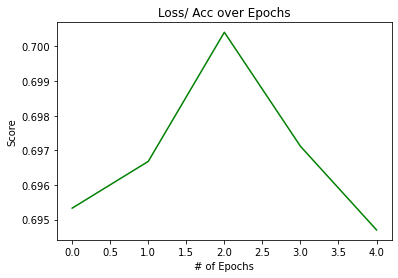

In [28]:
plt.plot(np.arange(0, len(log_loss), 1), log_loss, color='g')
plt.ylabel('Score')
plt.xlabel('# of Epochs')
plt.title('Loss/ Acc over Epochs')